In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import packages and formatting statements

import numpy as np
from matplotlib import pyplot as plt
import astropy.io.fits as pyfits
from astropy.table import Table, join, Column
from astropy.wcs import WCS
from astropy.io import ascii
import os

# plt.rc('text',usetex=False)
# fontsize=20
# plt.rc('xtick',labelsize=fontsize)
# plt.rc('ytick',labelsize=fontsize)

In [3]:
# Compile galaxy and OSC objects
# full catalog header: Name,Type,Host,RA hms,Dec dms,RA dds,Dec dds,DiscDate

DataFile = '../Data/2.MUSESampleCat.csv'
Data = Table.read(DataFile, format='csv') 

Data[0:5]

Galaxy,Distance,Incl,Supernova,Type,Ra,Dec,MUSERes,MUSENatMap,MUSE150pcMap,MUSEHII,IRACfiles,Intensity,coptMap,CO21,eCO21,InSample
str7,float64,float64,str11,str12,float64,float64,float64,str71,str70,str50,str40,float64,str58,str72,str73,str4
NGC1087,15.85,42.9,SN1995V,II,41.61152777777777,-0.4987861111111111,0.92,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1087-0.92asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1087-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1087_nebulae_mask_V2.fits,../Data/IRAC/ngc1087_irac1_atGauss4.fits,8.839672735197591e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1087_sfr.fits,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_co21_150pc_broad_emom0.fits,True
NGC1300,18.99,31.8,SN2022acko,II,49.91245833333333,-19.39518888888889,0.89,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1300-0.89asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1300-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1300_nebulae_mask_V2.fits,../Data/IRAC/ngc1300_irac1_atGauss4.fits,3.445745101042276e+38,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1300_sfr.fits,../../GalaxyFiles/ALMACO2-1/ngc1300_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc1300_12m+7m+tp_co21_150pc_broad_emom0.fits,True
NGC1365,19.57,55.4,SN1957C,Unclassified,53.38349999999999,-36.11770833333333,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,2.938518960212585e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1365_sfr.fits,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_co21_150pc_broad_emom0.fits,True
NGC1365,19.57,55.4,SN1983V,Ic,53.381876388888884,-36.14859166666667,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,1.4845660990817182e+40,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1365_sfr.fits,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_co21_150pc_broad_emom0.fits,True
NGC1365,19.57,55.4,SN2001du,II,53.3713125,-36.142111111111106,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,1.3530435354080875e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1365_sfr.fits,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_co21_150pc_broad_emom0.fits,True


In [4]:
IntensityFile = '../Data/2.Intensities.txt'
Ints = Table.read(IntensityFile, format='csv') 
Ints[0:5]

Supernova,Type,Int_native,Int_150,Int_1kpc
str11,str12,float64,float64,float64
SN2013ej,II,nan,nan,nan
SN2019krl,IIn/LBV,5.692852417108771e+38,0.7040593491199677,32.848532102709434
SN1995V,II,8.839672735197591e+39,6.599152737568015,233.44810259200804
SN2022acko,II,3.445745101042276e+38,0.5202362727946092,27.16511849663822
SN1957C,Unclassified,2.938518960212585e+39,3.036159738259367,139.56371405345993


In [5]:
ds = join(Data,Ints,keys=["Supernova","Type"])
ds

Galaxy,Distance,Incl,Supernova,Type,Ra,Dec,MUSERes,MUSENatMap,MUSE150pcMap,MUSEHII,IRACfiles,Intensity,coptMap,CO21,eCO21,InSample,Int_native,Int_150,Int_1kpc
str7,float64,float64,str11,str12,float64,float64,float64,str71,str70,str50,str40,float64,str58,str72,str73,str4,float64,float64,float64
NGC1566,17.69,29.5,ASASSN-14ha,II,65.0058875,-54.93807777777778,0.8,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1566-0.80asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1566-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1566_nebulae_mask_V2.fits,../Data/IRAC/ngc1566_irac1_atGauss4.fits,6.206906305070956e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1566_sfr.fits,../../GalaxyFiles/ALMACO2-1/ngc1566_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc1566_12m+7m+tp_co21_150pc_broad_emom0.fits,True,6.206906305070956e+39,5.912910765532021,149.07327510508023
NGC4321,15.21,38.5,SN1901B,I,185.6970833333333,15.82375,1.16,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC4321-1.16asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC4321-150pc_MAPS.fits,../Data/HII_reg_masks/NGC4321_nebulae_mask_V2.fits,../Data/IRAC/ngc4321_irac1_atGauss4.fits,2.1120944464704693e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC4321_sfr.fits,../../GalaxyFiles/ALMACO2-1/ngc4321_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc4321_12m+7m+tp_co21_150pc_broad_emom0.fits,True,2.1120944464704693e+39,1.8626634319160764,142.5743077637517
NGC4303,16.99,23.5,SN1926A,II,185.47536458333335,4.493354166666666,0.78,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC4303-0.78asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC4303-150pc_MAPS.fits,../Data/HII_reg_masks/NGC4303_nebulae_mask_V2.fits,../Data/IRAC/ngc4303_irac1_atGauss4.fits,8.237240338373292e+38,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC4303_sfr.fits,../../GalaxyFiles/ALMACO2-1/ngc4303_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc4303_12m+7m+tp_co21_150pc_broad_emom0.fits,True,8.237240338373292e+38,1.7137916507596849,121.43435581762041
NGC1365,19.57,55.4,SN1957C,Unclassified,53.38349999999999,-36.11770833333333,1.15,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1365-1.15asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC1365-150pc_MAPS.fits,../Data/HII_reg_masks/NGC1365_nebulae_mask_V2.fits,../Data/IRAC/ngc1365_irac1_atGauss4.fits,2.938518960212585e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1365_sfr.fits,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc1365_12m+7m+tp_co21_150pc_broad_emom0.fits,True,2.938518960212585e+39,3.036159738259367,139.56371405345993
NGC4321,15.21,38.5,SN1959E,I,185.74543194444445,15.816989814814816,1.16,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC4321-1.16asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC4321-150pc_MAPS.fits,../Data/HII_reg_masks/NGC4321_nebulae_mask_V2.fits,../Data/IRAC/ngc4321_irac1_atGauss4.fits,3.606657809150872e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC4321_sfr.fits,../../GalaxyFiles/ALMACO2-1/ngc4321_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc4321_12m+7m+tp_co21_150pc_broad_emom0.fits,True,3.606657809150872e+39,3.25662016729916,250.7948362963465
NGC4303,16.99,23.5,SN1961I,II,185.50184583333336,4.47037962962963,0.78,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC4303-0.78asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_150pc/NGC4303-150pc_MAPS.fits,../Data/HII_reg_masks/NGC4303_nebulae_mask_V2.fits,../Data/IRAC/ngc4303_irac1_atGauss4.fits,4.150635721869112e+39,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC4303_sfr.fits,../../GalaxyFiles/ALMACO2-1/ngc4303_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc4303_12m+7m+tp_co21_150pc_broad_emom0.fits,True,4.150635721869112e+39,6.2397444779131925,100.72224430268818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NGC1672,19.4,42.6,SN2017gax,Ib/c,71

In [6]:
# isolate discovery year
year = []
for j in range(len(Data)):
    yearDigits = [int(i) for i in Data["Supernova"][j] if i.isdigit()]
    # fix for ASAS-SN14
    if len(yearDigits)<4:
        yearDigits.insert(0,0)
        yearDigits.insert(0,2)
    yearDigits = int(''.join(map(str,yearDigits)))
    year.append(yearDigits)
    
    #flag SNe since 2000
goodSample = np.where(np.asarray(year) > 1999, 1, 0)
goodSample


array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1])

In [7]:
# homogonize type classifications
SNtype = Data["Type"]
for i in range(len(SNtype)):
    if "II" in SNtype[i]:
        SNtype[i] = "II"
    elif "Ia" in SNtype[i]:
        SNtype[i] = "Ia"
    elif "Ib" or "Ic" in SNtype[i]:
        SNtype[i] = "Ib/c"
    else:
        SNtype[i] = "Unclassified"
print(SNtype)


Type
----
  II
  II
Ib/c
Ib/c
  II
  Ia
  II
 ...
  Ia
  II
Ib/c
Ib/c
  Ia
Ib/c
Ib/c
Length = 33 rows


In [8]:
#get intensities
int_nat = ds["Int_native"]
int_150 = ds["Int_150"]
int_1kpc = ds["Int_1kpc"]

print(int_nat, int_150, int_1kpc)

      Int_native      
----------------------
 6.206906305070956e+39
2.1120944464704693e+39
 8.237240338373292e+38
 2.938518960212585e+39
 3.606657809150872e+39
 4.150635721869112e+39
2.9303903692530505e+38
                   ...
 4.185157273316843e+39
1.0400343563277594e+39
 2.199480578104416e+39
 5.473226299514552e+40
 1.263977781860364e+38
 9.694817596411935e+40
 3.445745101042276e+38
Length = 33 rows       Int_150      
-------------------
  5.912910765532021
 1.8626634319160764
 1.7137916507596849
  3.036159738259367
   3.25662016729916
 6.2397444779131925
 0.5211430559124834
                ...
   5.94440253509458
 0.6193577137788457
 1.6024194752980703
  49.78251306832529
0.23220293881842746
  29.76854206174491
 0.5202362727946092
Length = 33 rows      Int_1kpc     
------------------
149.07327510508023
 142.5743077637517
121.43435581762041
139.56371405345993
 250.7948362963465
100.72224430268818
40.424266689655006
               ...
 92.63588735906072
49.419701696492446
 82.589

In [9]:
# normalize intensities
int_nat = np.clip(int_nat,0,np.max(int_nat))
int_150 = np.clip(int_150,0,np.max(int_150))
int_1kpc = np.clip(int_1kpc,0,np.max(int_1kpc))

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

int_nat = normalize(int_nat)
int_150 = normalize(int_150)
int_1kpc = normalize(int_1kpc)

print(int_nat, int_150, int_1kpc)

      Int_native     
---------------------
   0.0496677000225231
 0.016900991932297747
0.0065914444657478085
 0.023514045653806062
 0.028860496573380776
 0.033213410965804324
 0.002344900062210418
                  ...
   0.0334896526194309
 0.008322360912875828
    0.017600256261224
  0.43796788389987673
0.0010114357494535602
   0.7757798627607313
0.0027572872155783227
Length = 33 rows       Int_150       
--------------------
 0.06058975161796576
0.019086761015495925
0.017561267971398155
0.031111608429127198
0.033370672224741466
 0.06393882523649365
0.005340166555401067
                 ...
 0.06091244860621196
0.006346574729198519
0.016420034369885386
  0.5101227164311125
0.002379389601139082
  0.3050390308719302
 0.00533087472502141
Length = 33 rows       Int_1kpc      
--------------------
0.048593810730976454
 0.04647532511570635
 0.03958427893047879
 0.04549395390183408
 0.08175225773164466
0.032832697024962616
0.013177205391583085
                 ...
0.030196765812310542
0.01

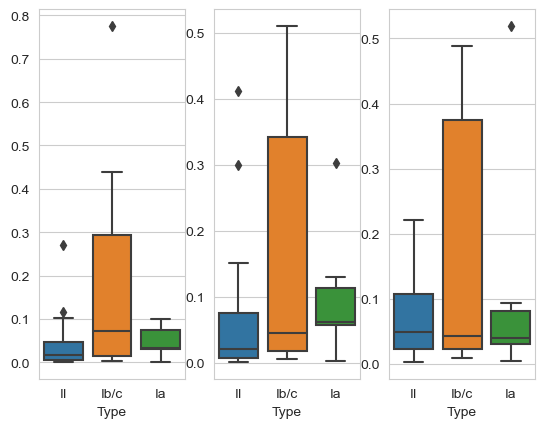

In [11]:
import seaborn as sns
sns.set_style("whitegrid")

fig,ax = plt.subplots(1,3)

sns.boxplot(y = int_nat, x = SNtype, ax=ax[0])
sns.boxplot(y = int_150, x = SNtype, ax=ax[1])
sns.boxplot(y = int_1kpc, x = SNtype, ax=ax[2])

# plt.yticks(fontsize=10)
# plt.xticks(fontsize=10)

# plt.ylabel("Intensity", fontsize=12)
# plt.xlabel("SNtype", fontsize=12)

plt.show()
fig.savefig("../Figures/IntensityViolin.pdf", dpi=300)